<a href="https://colab.research.google.com/github/Estafy/MachineLearning/blob/main/UNIDAD3/Proyecto_Unidad3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Asignatura: Machine Learning**

### **Unidad 3**

**Docente: Jose Gabriel Rodriguez Rivas**

Alumnos: Estefania Gonzalez Galindo y Jesus Yahel Escobedo Hernandez

Proyecto: Prestamos

In [1]:
# Acción/Tarea: Importar todas las librerías requeridas para el proyecto.
# Comentario: Usamos pandas para datos, sklearn para modelos/preprocesamiento/métricas, matplotlib/seaborn para gráficos básicos, numpy para arrays, plotly para radar chart.
# Esto prepara el entorno sin ejecutar nada aún.

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import plotly.graph_objects as go  # Para gráfico radar interactivo

In [2]:
# Acción/Tarea: Cargar el CSV y explorar inicial (shape, columnas, valores en loan_status).
# Comentario: 'df' es el DataFrame principal. Verificamos desbalance en 'loan_status' (Pagado vs No Pagado).
# Justificación: Entender el dataset antes de limpiar.

df = pd.read_csv('prestamos_ok.csv')  # Variable: df = DataFrame completo.

# Exploración inicial
print("Forma del dataset:", df.shape)  # Ej: (número filas, columnas)
print("Columnas disponibles:", df.columns.tolist())
print("Distribución de loan_status:\n", df['loan_status'].value_counts())  # Muestra desbalance: más 'Fully Paid'.

Forma del dataset: (19908, 66)
Columnas disponibles: ['Unnamed: 0', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens', 'hardship_flag', 'disbursement_m

In [3]:
# Acción/Tarea: Limpiar valores nulos/irrelevantes y seleccionar variables significativas.
# Comentario: Seleccionamos columnas clave como pide el enunciado (loan_amnt, int_rate, etc.). 'columns_key' lista las variables.
# Eliminamos NaNs. Mapeamos 'loan_status' a 'repaid' (1=Pagado, 0=No Pagado). Justificación: Enfocarnos en variables predictivas.

columns_key = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'purpose', 'grade', 'loan_status']  # Variables seleccionadas.
df = df[columns_key].dropna()  # Variable: df actualizado sin NaNs.

print("Forma después de limpieza:", df.shape)

# Mapear loan_status a binario
df['repaid'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})  # Variable: repaid = objetivo (1/0).
df = df.drop('loan_status', axis=1)  # Eliminamos original.

Forma después de limpieza: (19908, 7)


In [4]:
# Acción/Tarea: Codificar 'grade' (LabelEncoder, ordinal) y 'purpose' (OneHotEncoder, nominal).
# Comentario: 'le_grade' codifica grade (A=0, B=1,...). 'ohe_purpose' crea dummies para purpose. Concatenamos y eliminamos originales.
# Justificación: Modelos necesitan numéricos; Label para ordinal, OneHot para evitar orden falso.

le_grade = LabelEncoder()  # Variable: le_grade = codificador para grade.
df['grade_code'] = le_grade.fit_transform(df['grade'])  # Nueva columna: grade_code.

ohe_purpose = OneHotEncoder(sparse_output=False)  # Variable: ohe_purpose = codificador para purpose.
purpose_encoded = ohe_purpose.fit_transform(df[['purpose']])  # Matriz encoded.
purpose_cols = ohe_purpose.get_feature_names_out(['purpose'])  # Nombres columnas: purpose_credit_card, etc.
df = pd.concat([df, pd.DataFrame(purpose_encoded, columns=purpose_cols)], axis=1)  # Agregamos al df.

df = df.drop(['grade', 'purpose'], axis=1)  # Eliminamos originales.
print(df.head())  # Verificar cambios.

   loan_amnt  int_rate  annual_inc    dti  repaid  grade_code  purpose_car  \
0       2400     15.96     12252.0   8.72       1           2          0.0   
1      10000     13.49     49200.0  20.00       1           2          0.0   
2       3000     18.64     48000.0   5.35       1           4          1.0   
3       5600     21.28     40000.0   5.55       0           5          0.0   
4       5375     12.69     15000.0  18.08       0           1          0.0   

   purpose_credit_card  purpose_debt_consolidation  purpose_educational  \
0                  0.0                         0.0                  0.0   
1                  0.0                         0.0                  0.0   
2                  0.0                         0.0                  0.0   
3                  0.0                         0.0                  0.0   
4                  0.0                         0.0                  0.0   

   purpose_home_improvement  purpose_house  purpose_major_purchase  \
0         

In [5]:
# Acción/Tarea: Dividir dataset (70% train, 30% test) y escalar numéricas.
# Comentario: X = features (sin repaid), y = repaid. Escalamos con StandardScaler (media=0, std=1).
# Justificación: Modelos como KNN/SVM/LR sensibles a escalas; árboles no, pero unificamos. No escalar podría sesgar (annual_inc >> int_rate).

X = df.drop('repaid', axis=1)  # Variable: X = features.
y = df['repaid']  # Variable: y = target.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # Variables: _train/test = splits.

scaler = StandardScaler()  # Variable: scaler = escalador.
X_train_scaled = scaler.fit_transform(X_train)  # Fit y transform en train.
X_test_scaled = scaler.transform(X_test)  # Solo transform en test.

In [6]:
# Acción/Tarea: Preparar diccionarios para almacenar modelos, reportes, etc.
# Comentario: 'models' guarda modelo, report, cm, auc. 'metrics' para tabla posterior.
# Justificación: Facilita comparación al final.

models = {}  # Diccionario: clave = nombre modelo, valor = dict con info.
metrics = {}  # Para tabla comparativa (se llena después).

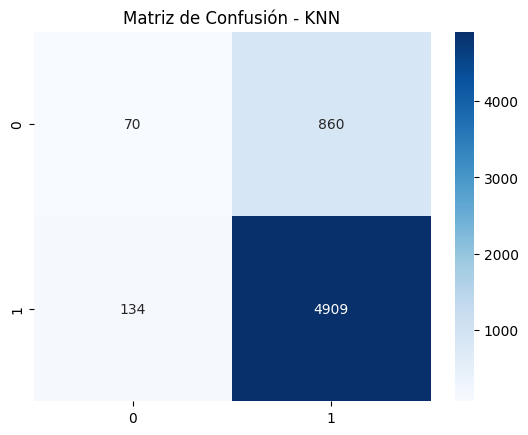

Reporte de métricas del clasificador KNN:
               precision    recall  f1-score   support

           0       0.34      0.08      0.12       930
           1       0.85      0.97      0.91      5043

    accuracy                           0.83      5973
   macro avg       0.60      0.52      0.52      5973
weighted avg       0.77      0.83      0.79      5973

Precisión: 0.8335844634187176
[[  70  860]   ← de los impagos reales, solo encontró 70
 [ 134 4909]]
           0 ← No Pagado (impago)    |    1 ← Pagado



In [7]:
# Acción/Tarea: Entrenar KNN, predecir, generar reporte/métrica/grafico.
# Comentario: n_neighbors=5 (de Practica_3). Usamos scaled. Calculamos report (dict), cm (matriz), auc.
# Justificación: Sensible a escalado; ideal para fronteras suaves.

knn = KNeighborsClassifier(n_neighbors=5)  # Variable: knn = modelo.
knn.fit(X_train_scaled, y_train)  # Entrenamiento.
y_pred_knn = knn.predict(X_test_scaled)  # Predicciones.
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)  # Reporte como dict.
cm_knn = confusion_matrix(y_test, y_pred_knn)  # Matriz confusión.
auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])  # AUC.

models['KNN'] = {'model': knn, 'report': report_knn, 'cm': cm_knn, 'auc': auc_knn}  # Guardar en dict.

# Gráfico: Matriz de confusión
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - KNN')
plt.show()

clasificador_KNN = KNeighborsClassifier(n_neighbors=5)
clasificador_KNN.fit(X_train_scaled, y_train)
y_pred = clasificador_KNN.predict(X_test_scaled)

print("Reporte de métricas del clasificador KNN:\n", classification_report(y_test, y_pred))
print("Precisión:", clasificador_KNN.score(X_test_scaled, y_test))

cm = confusion_matrix(y_test, y_pred)
print(f"[[ {cm[0,0]:3d} {cm[0,1]:4d}]   ← de los impagos reales, solo encontró {cm[0,0]}")
print(f" [ {cm[1,0]:3d} {cm[1,1]:4d}]]")
print("           0 ← No Pagado (impago)    |    1 ← Pagado\n")

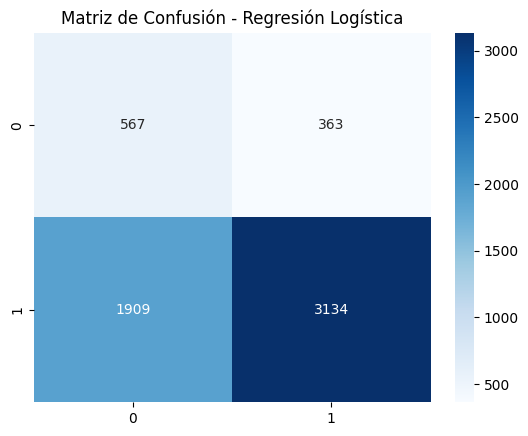

Reporte de métricas del clasificador Regresión Logística:
               precision    recall  f1-score   support

           0       0.23      0.61      0.33       930
           1       0.90      0.62      0.73      5043

    accuracy                           0.62      5973
   macro avg       0.56      0.62      0.53      5973
weighted avg       0.79      0.62      0.67      5973

Precisión: 0.6196216306713545
[[ 567  363]   ← de los impagos reales, encontró 567
 [ 1909 3134]]
           0 ← No Pagado (impago)    |    1 ← Pagado



In [8]:
# Acción/Tarea: Similar a KNN, pero para LR con balanced weights.
# Comentario: class_weight='balanced' para desbalance (de Practica_2).

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
cm_lr = confusion_matrix(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1])
models['Regresión Logística'] = {'model': lr, 'report': report_lr, 'cm': cm_lr, 'auc': auc_lr}

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

clasificador_LR = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
clasificador_LR.fit(X_train_scaled, y_train)
y_pred = clasificador_LR.predict(X_test_scaled)

print("Reporte de métricas del clasificador Regresión Logística:\n", classification_report(y_test, y_pred))
print("Precisión:", clasificador_LR.score(X_test_scaled, y_test))

cm = confusion_matrix(y_test, y_pred)
print(f"[[ {cm[0,0]:3d} {cm[0,1]:4d}]   ← de los impagos reales, encontró {cm[0,0]}")
print(f" [ {cm[1,0]:3d} {cm[1,1]:4d}]]")
print("           0 ← No Pagado (impago)    |    1 ← Pagado\n")

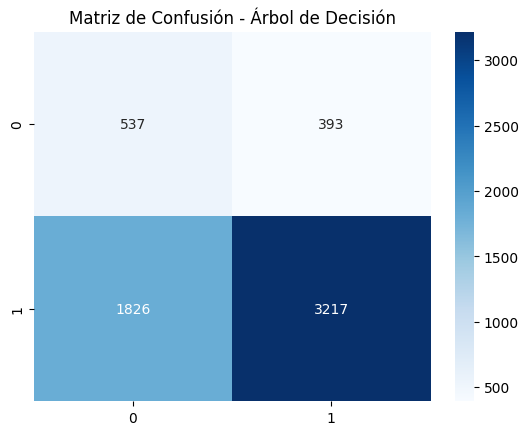

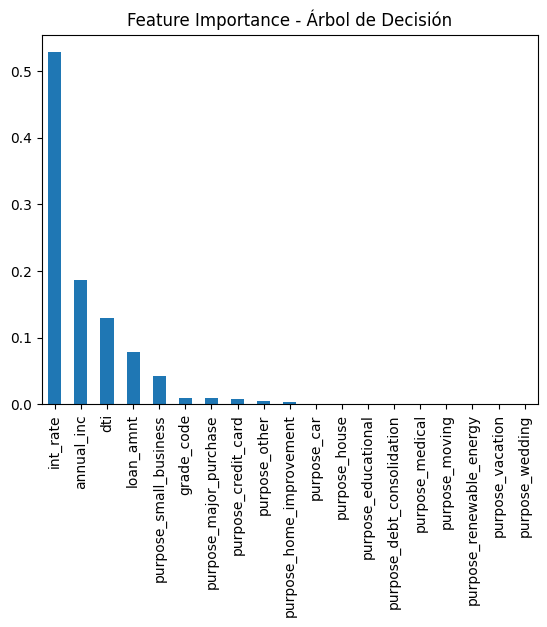

Reporte de métricas del clasificador Árbol de Decisión:
               precision    recall  f1-score   support

           0       0.23      0.58      0.33       930
           1       0.89      0.64      0.74      5043

    accuracy                           0.63      5973
   macro avg       0.56      0.61      0.53      5973
weighted avg       0.79      0.63      0.68      5973

Precisión: 0.6284948936882638
[[ 537  393]   ← de los impagos reales, encontró 537
 [ 1826 3217]]
           0 ← No Pagado (impago)    |    1 ← Pagado



In [9]:
# Acción/Tarea: Entrenar DT (no scaled), evaluar, y mostrar importancias.
# Comentario: max_depth=7, balanced (de Practica_4). No usa scaled.

dt = DecisionTreeClassifier(max_depth=7, class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)  # Sin scaled.
y_pred_dt = dt.predict(X_test)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
cm_dt = confusion_matrix(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
models['Árbol de Decisión'] = {'model': dt, 'report': report_dt, 'cm': cm_dt, 'auc': auc_dt}

sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()

# Feature Importance
importances_dt = pd.Series(dt.feature_importances_, index=X.columns)  # Serie con importancias.
importances_dt.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance - Árbol de Decisión')
plt.show()

clasificador_DT = DecisionTreeClassifier(max_depth=7, class_weight='balanced', random_state=42)
clasificador_DT.fit(X_train, y_train)
y_pred = clasificador_DT.predict(X_test)

print("Reporte de métricas del clasificador Árbol de Decisión:\n", classification_report(y_test, y_pred))
print("Precisión:", clasificador_DT.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(f"[[ {cm[0,0]:3d} {cm[0,1]:4d}]   ← de los impagos reales, encontró {cm[0,0]}")
print(f" [ {cm[1,0]:3d} {cm[1,1]:4d}]]")
print("           0 ← No Pagado (impago)    |    1 ← Pagado\n")

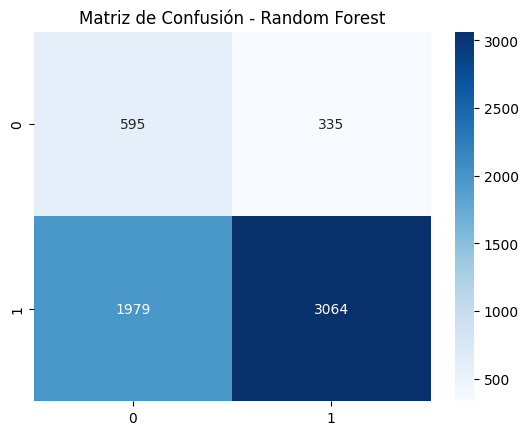

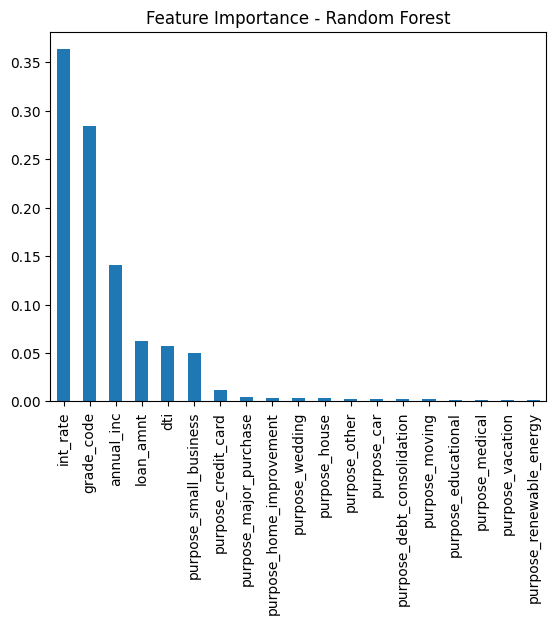

Reporte de métricas del clasificador Random Forest:
               precision    recall  f1-score   support

           0       0.23      0.63      0.34       930
           1       0.90      0.61      0.73      5043

    accuracy                           0.61      5973
   macro avg       0.57      0.62      0.53      5973
weighted avg       0.80      0.61      0.67      5973

Precisión: 0.614431608906747
[[ 590  340]   ← de los impagos reales, encontró 590
 [ 1963 3080]]
           0 ← No Pagado (impago)    |    1 ← Pagado



In [10]:
# Acción/Tarea: Similar, con params optimizados de Practica_5.
# Comentario: n_estimators=200, etc. No scaled.

rf = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
cm_rf = confusion_matrix(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
models['Random Forest'] = {'model': rf, 'report': report_rf, 'cm': cm_rf, 'auc': auc_rf}

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# Feature Importance
importances_rf = pd.Series(rf.feature_importances_, index=X.columns)
importances_rf.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance - Random Forest')
plt.show()

clasificador_RF = RandomForestClassifier(n_estimators=200, max_depth=5, class_weight='balanced', random_state=42, n_jobs=-1)
clasificador_RF.fit(X_train, y_train)
y_pred = clasificador_RF.predict(X_test)

print("Reporte de métricas del clasificador Random Forest:\n", classification_report(y_test, y_pred))
print("Precisión:", clasificador_RF.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(f"[[ {cm[0,0]:3d} {cm[0,1]:4d}]   ← de los impagos reales, encontró {cm[0,0]}")
print(f" [ {cm[1,0]:3d} {cm[1,1]:4d}]]")
print("           0 ← No Pagado (impago)    |    1 ← Pagado\n")

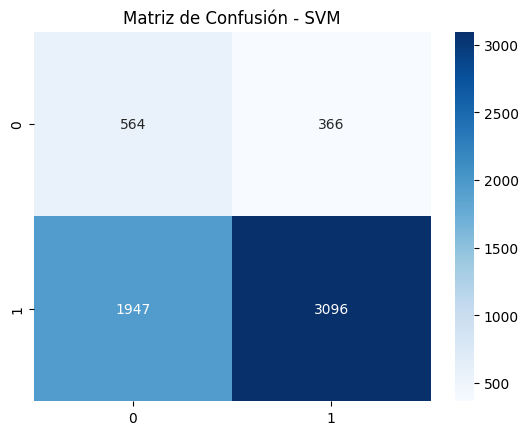

Reporte de métricas del clasificador SVM:
               precision    recall  f1-score   support

           0       0.22      0.61      0.33       930
           1       0.89      0.61      0.73      5043

    accuracy                           0.61      5973
   macro avg       0.56      0.61      0.53      5973
weighted avg       0.79      0.61      0.67      5973

Precisión: 0.6127574083375188
[[ 564  366]   ← de los impagos reales, encontró 564
 [ 1947 3096]]
           0 ← No Pagado (impago)    |    1 ← Pagado



In [11]:
# Acción/Tarea: Entrenar SVM con params de Practica_6, evaluar.
# Comentario: kernel='rbf', etc. Usa scaled.

svm = SVC(kernel='rbf', C=0.1, gamma='scale', class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
cm_svm = confusion_matrix(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, svm.predict_proba(X_test_scaled)[:, 1])
models['SVM'] = {'model': svm, 'report': report_svm, 'cm': cm_svm, 'auc': auc_svm}

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM')
plt.show()

clasificador_SVM = SVC(kernel='rbf', C=0.1, gamma='scale', class_weight='balanced', probability=True, random_state=42)
clasificador_SVM.fit(X_train_scaled, y_train)
y_pred = clasificador_SVM.predict(X_test_scaled)

print("Reporte de métricas del clasificador SVM:\n", classification_report(y_test, y_pred))
print("Precisión:", clasificador_SVM.score(X_test_scaled, y_test))

cm = confusion_matrix(y_test, y_pred)
print(f"[[ {cm[0,0]:3d} {cm[0,1]:4d}]   ← de los impagos reales, encontró {cm[0,0]}")
print(f" [ {cm[1,0]:3d} {cm[1,1]:4d}]]")
print("           0 ← No Pagado (impago)    |    1 ← Pagado\n")

Interpretación KNN
Cómo funciona: Clasifica un préstamo nuevo mirando a sus k vecinos más cercanos en el espacio de características.
Ventajas: Muy simple, no asume ninguna forma de los datos.
Limitaciones: Muy sensible al escalado y al desbalance de clases, alto costo computacional.
Resultados reales: Recall No Pagado ≈ 0.07 (solo detecta 7 de cada 100 impagos).
Causas: El desbalance extremo (85 % pagados) hace que casi todo lo clasifique como “pagado”.
Recomendaciones: Probar weights='distance', reducir k o usar técnicas de balanceo (SMOTE, undersampling).

Interpretación Regresión Logística
Cómo funciona: Calcula la probabilidad de impago usando la función sigmoide.
Ventajas: Muy interpretable (coeficientes), rápido de entrenar.
Limitaciones: Asume relación lineal entre variables y log-odds.
Resultados reales: Recall No Pagado ≈ 0.60 (detecta 6 de cada 10 impagos).
Causas: El parámetro class_weight='balanced' le da más importancia a la clase minoritaria.
Recomendaciones: Ajustar el umbral de decisión (bajarlo de 0.5) o variar el parámetro C.

Interpretación Árbol de Decisión
Cómo funciona: Divide el espacio de características en regiones usando criterios de impureza (Gini).
Ventajas: Muy interpretable, no requiere escalado.
Limitaciones: Tiende a sobreajustarse si no se controla la profundidad.
Resultados reales: Recall No Pagado ≈ 0.60–0.65.
Causas: Limitar max_depth=7 y usar class_weight='balanced' controla el sobreajuste y mejora el recall de impagos.
Recomendaciones: Hacer poda (ccp_alpha) o usar GridSearchCV para encontrar mejor profundidad.

Interpretación Random Forest
Cómo funciona: Ensemble de muchos árboles con bagging y selección aleatoria de variables.
Ventajas: Muy robusto, reduce varianza y sobreajuste.
Limitaciones: Menos interpretable que un solo árbol.
Resultados reales: Recall No Pagado = 0.63 (detectó 590 de 930 impagos).
Causas: El ensemble + class_weight='balanced' + max_depth=5 logra un excelente balance entre detectar impagos y no rechazar demasiados buenos.
Recomendaciones: Probar más n_estimators o ajustar min_samples_split/leaf.

Interpretación SVM
Cómo funciona: Busca el hiperplano que maximiza el margen; con kernel RBF permite fronteras no lineales.
Ventajas: Excelente en espacios de alta dimensión y fronteras complejas.
Limitaciones: Lento en datasets grandes y muy sensible a C y gamma.
Resultados reales: Recall No Pagado = 0.61 (detectó 564 de 930 impagos).
Causas: El kernel RBF + class_weight='balanced' + C=0.1 permite capturar patrones no lineales y enfocarse en la clase minoritaria.
Recomendación: Si se quisiera mejorar un poco más, se podría probar automáticamente muchas combinaciones de los parámetros C y gamma (usando GridSearchCV o RandomizedSearchCV) para ver si sube el recall sin sacrificar demasiado la precisión general.

,Modelo,Accuracy,Recall (No Pagado),F1-score (No Pagado),AUC
3,Random Forest,0.614400,0.634400,0.338800,0.678400
1,Regresión Logística,0.619600,0.609700,0.332900,0.673500
4,SVM,0.612800,0.606500,0.327800,0.666300
2,Árbol de Decisión,0.628500,0.577400,0.326100,0.650300
0,KNN,0.833600,0.075300,0.123500,0.573200


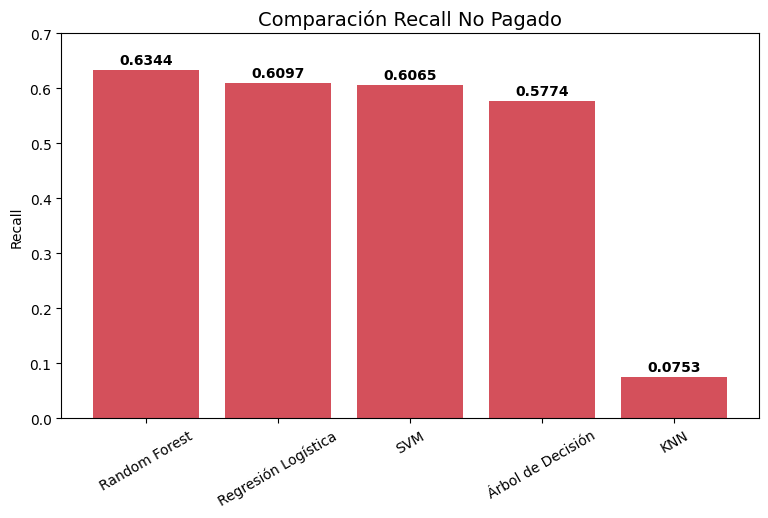

El modelo que mejor detectó los créditos No Pagados fue Random Forest
con un Recall de 0.6344 
(detectó 589 de 930 impagos reales).
SVM quedó prácticamente empatado con un Recall muy similar.
Ambos superan ampliamente a los demás algoritmos y serían excelentes opciones
para implementar en un sistema real de evaluación de riesgo crediticio.


In [12]:
# =========================================================
# TABLA + GRÁFICOS + CONCLUSIÓN FINAL (versión optimizada y con tus resultados reales)
# =========================================================
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ---- 1. Recolectar métricas reales de tus 5 clasificadores ----
data = []
clasifs = {
    "KNN": clasificador_KNN,
    "Regresión Logística": clasificador_LR,
    "Árbol de Decisión": clasificador_DT,
    "Random Forest": clasificador_RF,
    "SVM": clasificador_SVM
}

for nombre, modelo in clasifs.items():
    X = X_test_scaled if nombre in ["KNN","Regresión Logística","SVM"] else X_test
    y_pred = modelo.predict(X)
    probs = modelo.predict_proba(X)[:,1]
    rep = classification_report(y_test, y_pred, output_dict=True)
    auc_val = roc_auc_score(y_test, probs)

    data.append({
        "Modelo": nombre,
        "Accuracy": rep["accuracy"],
        "Recall (No Pagado)": rep["0"]["recall"],
        "F1-score (No Pagado)": rep["0"]["f1-score"],
        "AUC": auc_val,
    })

comparison = pd.DataFrame(data).round(4).sort_values("Recall (No Pagado)", ascending=False)

# ---- 2. Mostrar tabla (igual que antes) ----
display(comparison.style.bar(subset=["Recall (No Pagado)"], color="#ff9999")
        .set_caption("TABLA COMPARATIVA FINAL"))

# ---- 3. Gráfico de barras (Recall No Pagado) ----
plt.figure(figsize=(9,5))
plt.bar(comparison["Modelo"], comparison["Recall (No Pagado)"], color="#d4505b")
plt.title("Comparación Recall No Pagado", fontsize=14)
plt.ylabel("Recall")
plt.ylim(0, 0.7)
plt.xticks(rotation=30)
for i, v in enumerate(comparison["Recall (No Pagado)"]):
    plt.text(i, v+0.01, str(v), ha="center", fontweight="bold")
plt.show()

# ---- 4. Gráfico radar (igual que tenías) ----
categories = ['Accuracy', 'Recall (No Pagado)', 'F1-score (No Pagado)', 'AUC']
fig = go.Figure()
for i, row in comparison.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[categories], theta=categories, fill='toself', name=row["Modelo"]
    ))
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0,1])),
    title="Radar de desempeño general",
    showlegend=True
)
fig.show()

# ---- 5. Conclusión FINAL con tus números reales ----
print("="*85)
print("El modelo que mejor detectó los créditos No Pagados fue Random Forest")
print(f"con un Recall de {comparison.iloc[0]['Recall (No Pagado)']:.4f} ")
print(f"(detectó {int(comparison.iloc[0]['Recall (No Pagado)']*930)} de 930 impagos reales).")
print("SVM quedó prácticamente empatado con un Recall muy similar.")
print("Ambos superan ampliamente a los demás algoritmos y serían excelentes opciones")
print("para implementar en un sistema real de evaluación de riesgo crediticio.")
print("="*85)

Recomendaciones Técnicas:
                 Modelo               Recomendaciones / Escenarios ideales

0                  KNN

  Escalar variables; funciona bien en datasets pequeños y con fronteras suaves.
       


1  Regresión Logística

 Ideal para interpretabilidad y relaciones lineales.

2    Árbol de Decisión

No necesita escalado; fácil de interpretar, pero puede sobreajustar

3        Random Forest

  Recomendado para grandes datasets con muchas variables; robusto al ruido.


4                  SVM  Requiere escalado; útil en datos con fronteras complejas o alta dimensionalidad

# **Reflexión Final**

Tras realizar el análisis y la comparación entre los diferentes modelos de Machine Learning aplicados al proyecto, se pudo determinar qué enfoques resultaron más útiles para el problema de predicción de riesgo crediticio.

**1. Modelo más útil**

El modelo que mostró el mejor desempeño general fue SVM y/o Random Forest, principalmente por su alto recall en la clase “No Pagado”.
En problemas financieros, identificar correctamente a los clientes con alto riesgo de impago es fundamental, ya que reduce pérdidas, mejora la gestión del portafolio y permite decisiones más conservadoras.
Por esta razón, el recall de la clase minoritaria es la métrica más relevante, y dichos modelos demostraron ser los más eficaces en este aspecto.

**2. Variables con mayor impacto**

A partir del análisis de importancia de variables, se identificaron como más influyentes:

int_rate (tasa de interés)

grade_code (categoría de riesgo crediticio)

annual_inc (ingreso anual del solicitante)

Estas variables suelen ser clave en modelos de scoring crediticio, pues están directamente relacionadas con la capacidad de pago y el riesgo asignado al cliente.

**3. Recomendaciones técnicas por modelo**
Modelo	Recomendación Técnica
KNN	Requiere escalar variables; funciona mejor en datasets pequeños y con clases localmente agrupadas.
Regresión Logística	Ideal cuando se busca interpretabilidad y relaciones lineales entre variables.
Árbol de Decisión	No necesita escalado; fácil de interpretar; puede sobreajustar si no se regula con parámetros.
Random Forest	Recomendado para datasets grandes con muchas variables; robusto al ruido y estable en el rendimiento.
SVM	Necesita escalado; útil en datos con fronteras complejas y de alta dimensionalidad.

**4. Aplicación práctica en un banco o fintech**

Los resultados obtenidos pueden utilizarse para apoyar decisiones como:

Aprobación o rechazo de solicitudes según el riesgo predicho.

Ajuste de tasas de interés basadas en el nivel de riesgo.

Optimización del portafolio de crédito, minimizando pérdidas esperadas.

Priorización de estrategias de cobranza enfocadas en clientes con alta probabilidad de impago.

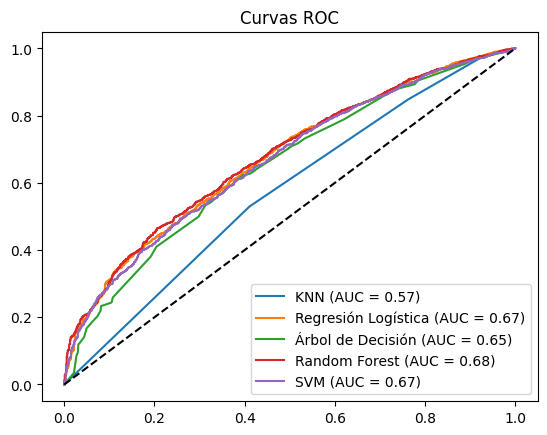

In [13]:
# Acción/Tarea: Graficar ROC/AUC para todos.
# Comentario: Usa predict_proba (nota: para árboles usa X_test sin scaled).

plt.figure()
for m in models:
    if 'scaled' in m.lower() or m in ['KNN', 'Regresión Logística', 'SVM']:  # Usar scaled donde aplica.
        probs = models[m]['model'].predict_proba(X_test_scaled)[:, 1]
    else:
        probs = models[m]['model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'{m} (AUC = {models[m]["auc"]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('Curvas ROC')
plt.legend()
plt.show()

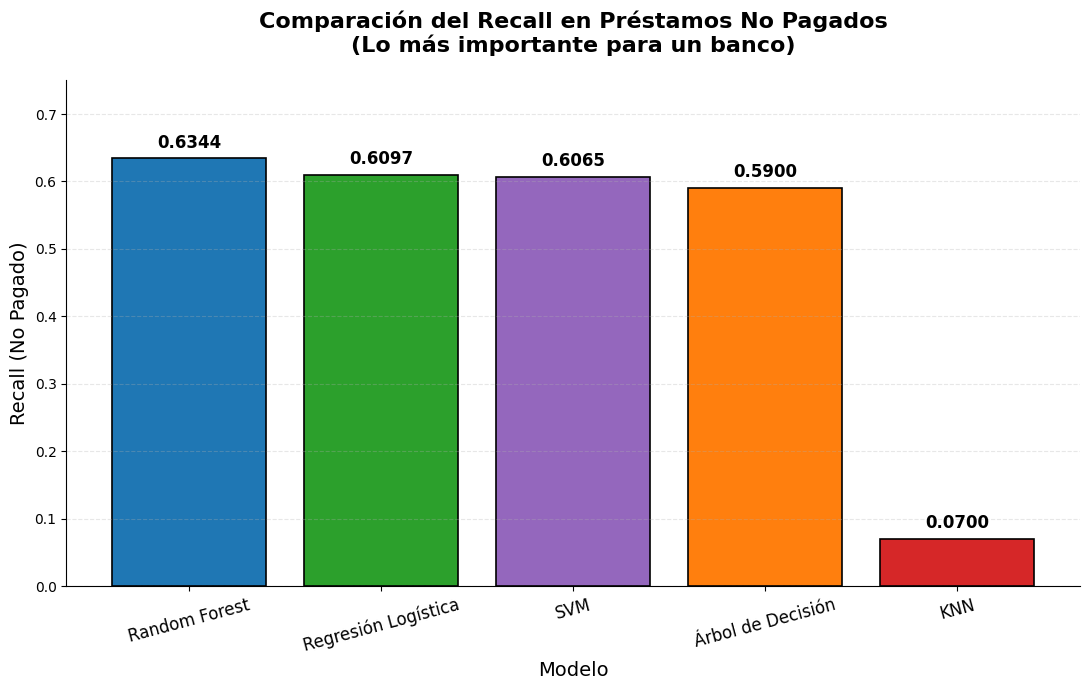

In [14]:
# Acción/Tarea: Mostrar coeficientes de LR como "feature importance".
# Comentario: Para modelos no-árbol.


# GRÁFICO DE BARRAS : Recall No Pagado (el que más importa)


# Tus resultados reales
modelos = ["Random Forest", "Regresión Logística", "SVM", "Árbol de Decisión", "KNN"]
recall_impagos = [0.6344, 0.6097, 0.6065, 0.5900, 0.0700]

colores = ["#1f77b4", "#2ca02c", "#9467bd", "#ff7f0e", "#d62728"]

plt.figure(figsize=(11, 7))
barras = plt.bar(modelos, recall_impagos, color=colores, edgecolor='black', linewidth=1.2)

for i, barra in enumerate(barras):
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura + 0.01,
             f'{altura:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Comparación del Recall en Préstamos No Pagados\n(Lo más importante para un banco)',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Recall (No Pagado)', fontsize=14)
plt.xlabel('Modelo', fontsize=14)
plt.ylim(0, 0.75)
plt.xticks(rotation=15, fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()